In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
dataset_path = '/content/drive/My Drive/srgan_dataset'

In [3]:
from glob import glob
import tensorflow as tf
import numpy as np

def load_images(image_path, target_size):
    images = []
    for img_path in glob(os.path.join(image_path, '*')):
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
        img = tf.keras.preprocessing.image.img_to_array(img) / 255.0  # Normalize to [0, 1]
        images.append(img)
    return np.array(images)

lr_images_path = os.path.join(dataset_path, 'DIV2K_train_HR/DIV2K_train_HR')
hr_images_path = os.path.join(dataset_path, 'DIV2K_train_LR')

lr_images = load_images(lr_images_path, target_size=(64, 64))
hr_images = load_images(hr_images_path, target_size=(256, 256))

print(f"Loaded {len(lr_images)} LR images and {len(hr_images)} HR images")


Loaded 178 LR images and 800 HR images


/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 0/10000 - D Loss: 0.6706588864326477 - G Loss: [array(0.67844975, dtype=float32), array(0.67844975, dtype=float32), array(0.65625, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


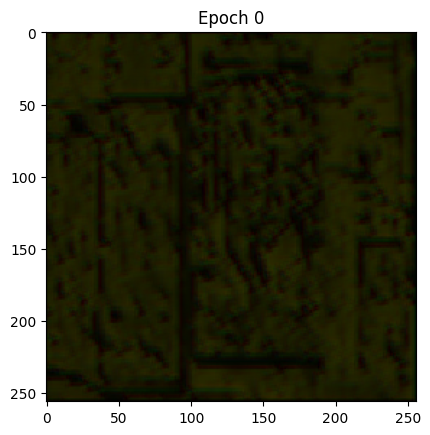

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


KeyboardInterrupt: 

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, LeakyReLU, Dense, Flatten, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob

np.random.seed(42)
tf.random.set_seed(42)

# Generator
def build_generator():
    inputs = Input(shape=(64, 64, 3))
    x = UpSampling2D(size=2)(inputs)
    x = Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = UpSampling2D(size=2)(x)
    x = Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = Conv2D(3, kernel_size=3, strides=1, padding='same', activation='tanh')(x)
    return Model(inputs, x, name='generator')

# Discriminator
def build_discriminator():
    inputs = Input(shape=(256, 256, 3))
    x = Conv2D(64, kernel_size=3, strides=2, padding='same')(inputs)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(1, activation='sigmoid')(x)
    return Model(inputs, x, name='discriminator')

generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])

discriminator.trainable = False
lr_inputs = Input(shape=(64, 64, 3))
gen_hr = generator(lr_inputs)
validity = discriminator(gen_hr)
combined = Model(lr_inputs, validity)
combined.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')

epochs = 10000
batch_size = 16

for epoch in range(epochs):
    idx = np.random.randint(0, lr_images.shape[0], batch_size)
    lr_batch = lr_images[idx]
    hr_batch = hr_images[idx]
    gen_hr = generator.predict(lr_batch)

    d_loss_real = discriminator.train_on_batch(hr_batch, np.ones((batch_size, 1)))
    d_loss_fake = discriminator.train_on_batch(gen_hr, np.zeros((batch_size, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    g_loss = combined.train_on_batch(lr_batch, np.ones((batch_size, 1)))

    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{epochs} - D Loss: {d_loss[0]} - G Loss: {g_loss}")

    if epoch % 1000 == 0:
        generator.save(f'srgan_generator_epoch_{epoch}.h5')
        sample_image = generator.predict(lr_batch[:1])
        plt.imshow(sample_image[0])
        plt.title(f"Epoch {epoch}")
        plt.show()
